In [1]:
# 기본 라이브러리, 데이터 불러오기

import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from ydata_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from datetime import datetime

#한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'

# 마이너스 부호 깨짐 지정
plt.rcParams['axes.unicode_minus'] = False

# 데이터 불러오기
df = pd.read_csv("dataset/instax_sales_transaction_data.csv")

print("="*50) # '='이거를 50개 나오게해
print("데이터셋 기본정보")
print("="*50)

print(f"전체 데이터 개수:{len(df)} 행") #len: 행의 개수
print(f"컬럼 개수: {len(df.columns)} 개")
print("\n 데이터 상위 5개 행:")
print(df.head()) #df.head() : 상위 5개 행만 보여줘


데이터셋 기본정보
전체 데이터 개수:12334 행
컬럼 개수: 12 개

 데이터 상위 5개 행:
      Tanggal  Tahun  Bulan    Hari Kategori             Nama_Produk  \
0  2022-05-01   2022      5  Sunday     Film  Instax Mini Film (20s)   
1  2022-05-01   2022      5  Sunday     Film  Instax Mini Film (20s)   
2  2022-05-01   2022      5  Sunday     Film  Instax Mini Film (20s)   
3  2022-05-01   2022      5  Sunday   Kamera          Instax Mini 11   
4  2022-05-01   2022      5  Sunday     Film  Instax Mini Film (20s)   

          Lokasi_Toko          Metode_Bayar  Harga_Satuan  Qty  Diskon_IDR  \
0  Tokopedia Official          Kartu Kredit        185000    1        9250   
1  Tokopedia Official          Kartu Kredit        185000    1           0   
2         Shopee Mall  E-Wallet (Gopay/OVO)        185000    2           0   
3         Shopee Mall              Paylater       1100000    1           0   
4         Shopee Mall  E-Wallet (Gopay/OVO)        185000    2           0   

   Total_Penjualan  
0           175750  
1

In [2]:
# 기본 데이터 정보 확인

print("\n컬럼명 확인:")
print(df.columns.tolist())

#사용해야할 데이터중에서 전처리를 어떤거해야하는지 확인하기 위해서 실행
print("\n데이터 타입 확인:")
print(df.dtypes)
print(f"총 판매수량: {df['Qty'].sum():,}개")


컬럼명 확인:
['Tanggal', 'Tahun', 'Bulan', 'Hari', 'Kategori', 'Nama_Produk', 'Lokasi_Toko', 'Metode_Bayar', 'Harga_Satuan', 'Qty', 'Diskon_IDR', 'Total_Penjualan']

데이터 타입 확인:
Tanggal            object
Tahun               int64
Bulan               int64
Hari               object
Kategori           object
Nama_Produk        object
Lokasi_Toko        object
Metode_Bayar       object
Harga_Satuan        int64
Qty                 int64
Diskon_IDR          int64
Total_Penjualan     int64
dtype: object
총 판매수량: 23,938개


In [3]:
# 결측치 확인 (결측치: null값) 널값이 있으면 계산을 못하고 에러를 발생시킴
print("\n 결측치 확인:")
print(df.isnull().sum())
print("\n 중복값 현황:")
print(f"중복된 데이터 개수 : {df.duplicated().sum()}개")


print("\n 기술 통계량")
print(df.describe())


 결측치 확인:
Tanggal            0
Tahun              0
Bulan              0
Hari               0
Kategori           0
Nama_Produk        0
Lokasi_Toko        0
Metode_Bayar       0
Harga_Satuan       0
Qty                0
Diskon_IDR         0
Total_Penjualan    0
dtype: int64

 중복값 현황:
중복된 데이터 개수 : 129개

 기술 통계량
              Tahun         Bulan  Harga_Satuan           Qty    Diskon_IDR  \
count  12334.000000  12334.000000  1.233400e+04  12334.000000  1.233400e+04   
mean    2023.485244      6.790011  3.989071e+05      1.940814  1.290899e+04   
std        0.928167      3.872200  6.915002e+05      1.151353  4.618240e+04   
min     2022.000000      1.000000  5.000000e+04      1.000000  0.000000e+00   
25%     2023.000000      3.000000  9.500000e+04      1.000000  0.000000e+00   
50%     2024.000000      7.000000  1.500000e+05      2.000000  0.000000e+00   
75%     2024.000000     10.000000  1.850000e+05      3.000000  7.500000e+03   
max     2025.000000     12.000000  2.900000e+06      5.0

In [4]:
# 날짜와 할인금액 정보를 기반으로 판매량 분석
print("\n" + "="*50)
print("데이터 전처리 시작")
print("="*50)

# 날짜 전처리(문자-> 숫자(월/month)로 변경)
# 날짜 컬럼을 datetime으로 변환
df['Tanggal'] = pd.to_datetime(df['Tanggal'])

# 월(month) 정보 추출 / Tanggal을 사용하지 않고 가공된 Month를 사용할거야
df['Month'] = df['Tanggal'].dt.month

# 이진화: 할인여부를 논리적인상태로 단순화 할때 사용하는것.
#Diskon_IDR이 0보다 크면 1로 하고 아니면 0으로 해
df['is_dc'] = np.where(df['Diskon_IDR'] > 0, 1, 0)


# 요일 전처리
day = {'Monday':0, 'Tuesday': 1, 'Wednesday': 2, 
    'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6}
df['day_of_week'] = df['Hari'].map(day)

# 전처리 된 데이터 다시 확인
print("======전처리 데이터 확인 ======")
print(df.head())


데이터 전처리 시작
======전처리 데이터 확인 ======
     Tanggal  Tahun  Bulan    Hari Kategori             Nama_Produk  \
0 2022-05-01   2022      5  Sunday     Film  Instax Mini Film (20s)   
1 2022-05-01   2022      5  Sunday     Film  Instax Mini Film (20s)   
2 2022-05-01   2022      5  Sunday     Film  Instax Mini Film (20s)   
3 2022-05-01   2022      5  Sunday   Kamera          Instax Mini 11   
4 2022-05-01   2022      5  Sunday     Film  Instax Mini Film (20s)   

          Lokasi_Toko          Metode_Bayar  Harga_Satuan  Qty  Diskon_IDR  \
0  Tokopedia Official          Kartu Kredit        185000    1        9250   
1  Tokopedia Official          Kartu Kredit        185000    1           0   
2         Shopee Mall  E-Wallet (Gopay/OVO)        185000    2           0   
3         Shopee Mall              Paylater       1100000    1           0   
4         Shopee Mall  E-Wallet (Gopay/OVO)        185000    2           0   

   Total_Penjualan  Month  is_dc  day_of_week  
0           175750  

In [5]:
# EDA
print("\n" + "=" * 50)
print("탐색적 테이터 분석 (EDA)")
print("=" * 50)

# 할인 금액 분포 확인
print("\n할인 금액 통계:")
print(df['Diskon_IDR'].describe())

# 판매량 분포 확인
print("\n판매량 통계:")
print(df['Qty'].describe())

# 월별 판매 패턴 확인
print("\n월별 평균 판매량:")
monthly_sales = df.groupby('Month')['Qty'].mean().sort_index()
print(monthly_sales)

# 할인 여부에 따른 판매량 비교
df['할인여부'] = df['Diskon_IDR'] > 0
print("\n할인 여부에 따른 평균 판매량:")
print(df.groupby('할인여부')['Qty'].mean())

# 상관관계분석
print("\n주요 변수 간 상관관계")
corr_matrix = df[['Diskon_IDR', 'Month','Qty']].corr()
print(corr_matrix)


탐색적 테이터 분석 (EDA)

할인 금액 통계:
count    1.233400e+04
mean     1.290899e+04
std      4.618240e+04
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      7.500000e+03
max      1.160000e+06
Name: Diskon_IDR, dtype: float64

판매량 통계:
count    12334.000000
mean         1.940814
std          1.151353
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          5.000000
Name: Qty, dtype: float64

월별 평균 판매량:
Month
1     1.936954
2     1.913043
3     1.957627
4     1.899767
5     1.923523
6     1.900850
7     1.888480
8     2.002871
9     2.027027
10    1.968825
11    1.965475
12    1.920761
Name: Qty, dtype: float64

할인 여부에 따른 평균 판매량:
할인여부
False    1.949537
True     1.919611
Name: Qty, dtype: float64

주요 변수 간 상관관계
            Diskon_IDR     Month       Qty
Diskon_IDR    1.000000  0.240668 -0.028509
Month         0.240668  1.000000  0.006815
Qty          -0.028509  0.006815  1.000000


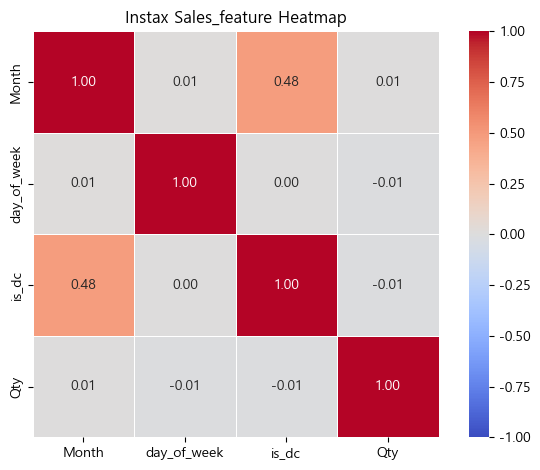


📊 상관관계 분석 결과
                Month  day_of_week     is_dc       Qty
Month        1.000000     0.014461  0.477487  0.006815
day_of_week  0.014461     1.000000  0.004001 -0.013588
is_dc        0.477487     0.004001  1.000000 -0.011812
Qty          0.006815    -0.013588 -0.011812  1.000000

💡 주요 인사이트:
• 할인여부 ↔ 판매량 상관계수: -0.012
• 월 ↔ 판매량 상관계수: 0.007
• 요일 ↔ 판매량 상관계수: -0.014


In [6]:
# 히트맵 그리기
plt.Figure(figsize=(10,8))

model_features = df[['Month', 'day_of_week', 'is_dc', 'Qty']] #예측에 사용할 변수

sns.heatmap(
    model_features.corr(numeric_only=True), 
    annot=True, #숫자표시해
    cmap='coolwarm', #색상
    fmt=".2f", # 소수점 2자리
     vmin=-1, vmax=1,  # 상관계수 범위 (-1 ~ 1)
    square=True,  # 정사각형으로
    linewidths=0.5  # 격자선
)
plt.title("Instax Sales_feature Heatmap")
plt.tight_layout()
plt.show()

print("\n📊 상관관계 분석 결과")
print("=" * 50)
corr_matrix = model_features.corr()
print(corr_matrix)
print("\n💡 주요 인사이트:")
print(f"• 할인여부 ↔ 판매량 상관계수: {corr_matrix.loc['is_dc', 'Qty']:.3f}")
print(f"• 월 ↔ 판매량 상관계수: {corr_matrix.loc['Month', 'Qty']:.3f}")
print(f"• 요일 ↔ 판매량 상관계수: {corr_matrix.loc['day_of_week', 'Qty']:.3f}")

In [7]:
# 원인/지료 features(특성/변수) 모델이 학습할 때 참고하는 원인이나 힌트가 되는 데이터.
    # 결과 target 모델이 최종적으로 예측하고 싶어하는 결과물
    # df : data frame의 약자/ 파이썬 안에서 쓰는 엑셀 표

print("\n" + "=" * 50)
print("모델 학습 준비")
print("=" * 50)    

features = [
    'is_dc', #할인여부
    'Month', #판매월
    'day_of_week' #요일
]

# sub_features = ['Month'] #판매월 -> 2차원 데이터로 만들어야함.
# 1차원 데이터 : 나열된 데이터 , 2차원 데이터 : 표, 3차원 데이터 : 큐브 그래프

target = 'Qty' #판매량

# .copy()는 df값이 바뀔수도 있기때문에 복사본으로 별도 저장할거야.
# 할인이 없을때 판매량 예측
df_no_dc = df[df['is_dc'] ==0].copy() #[조건값]안에 있는 결과값으로 해서 목록을 표로 만들어줘
# 할인있을때 판매량 예측
df_yes_dc = df[df['is_dc']==1].copy()

# X = features, y = target 분리
X = df[features]
y = df[target]

X_no_dc = df_no_dc[features]
y_no_dc = df_no_dc[target]

X_yes_dc = df_yes_dc[features]
y_yes_dc = df_yes_dc[target]

print(f"총 학습 데이터 개수: {len(X):,} 개\n{'=' * 50}")
print(f" no 할인 학습 데이터 개수: {len(X_no_dc):,} 개\n{'=' * 50}")
print(f" yes 할인 학습 데이터 개수: {len(X_yes_dc):,} 개\n{'=' * 50}")



모델 학습 준비
총 학습 데이터 개수: 12,334 개
 no 할인 학습 데이터 개수: 8,739 개
 yes 할인 학습 데이터 개수: 3,595 개


In [8]:
# 학습/test 분리 , 데이터에서 20%만 테스트할거야
# 42이 숫자에 대한 의미는 크게 없으며, 다른 숫자를 적어도 가능함. 범주가 고정된 랜덤방식 사용.
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

# no dc
X_train_no_dc, X_test_no_dc, y_train_no_dc, y_test_no_dc = train_test_split(
    X_no_dc,
    y_no_dc,
    test_size=0.2,
    random_state=42
)

# yes dc
X_train_yes_dc, X_test_yes_dc, y_train_yes_dc, y_test_yes_dc = train_test_split(
    X_yes_dc,
    y_yes_dc,
    test_size=0.2,
    random_state=42
)

print(f"* 총 학습 데이터: {len(X_train):,} 개 / 테스트 데이터: {len(X_test):,} 개")
print(f"* no dc 학습 데이터: {len(X_train_no_dc):,} 개 / 테스트 데이터: {len(X_test_no_dc):,} 개")
print(f"* yes dc 학습 데이터: {len(X_train_yes_dc):,} 개 / 테스트 데이터: {len(X_test_yes_dc):,} 개")

* 총 학습 데이터: 9,867 개 / 테스트 데이터: 2,467 개
* no dc 학습 데이터: 6,991 개 / 테스트 데이터: 1,748 개
* yes dc 학습 데이터: 2,876 개 / 테스트 데이터: 719 개


In [9]:
# 스케일링 /숫자가 크더라도 공정하게 데이터를 판단해서 처리할수 있도록 하는 기능 
# -> 데이터의 영향력을 공평하게 맞춰주는 작업 월은 1~12월이기때문에 편차가 커서 컴퓨터가 '월'이 더 중요한 숫자라고 오해하여
# 잘못된 예측을 할수 있기때문에 해야함

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train) #이 학습 데이터로 기준을 세움 
# fit은 한번만 해야해 이게 기준점이 되거든

X_test_scaled = scaler.transform(X_test) #세워진 기준에 맞춰서 변환해봐.

X_train_no_dc_scaled = scaler.transform(X_train_no_dc)
X_test_no_dc_scaled = scaler.transform(X_test_no_dc)

X_train_yes_dc_scaled = scaler.transform(X_train_yes_dc)
X_test_yes_dc_scaled = scaler.transform(X_test_yes_dc)

print("\n데이터 스케일링 완료")
print(f"원본 데이터 예시:\n{X_train.head()}"
      f"\n스케일링된 데이터 예시:\n{X_train_scaled[:5]}") #앞에서5개만 보여줘

print(f"\nno dc원본 데이터 예시:\n{X_train_no_dc.head()}"
      f"\n스케일링된 데이터 예시:\n{X_train_no_dc_scaled[:5]}")

print(f"\nyes dc원본 데이터 예시:\n{X_train_yes_dc.head()}"
      f"\n스케일링된 데이터 예시:\n{X_train_yes_dc_scaled[:5]}")



데이터 스케일링 완료
원본 데이터 예시:
       is_dc  Month  day_of_week
1785       1     12            4
9468       0     11            3
286        0      6            5
10856      0      1            4
3844       0      7            2
스케일링된 데이터 예시:
[[ 1.55528741  1.34830925  0.33723293]
 [-0.64296798  1.08987327 -0.15836989]
 [-0.64296798 -0.20230663  0.83283574]
 [-0.64296798 -1.49448652  0.33723293]
 [-0.64296798  0.05612935 -0.6539727 ]]

no dc원본 데이터 예시:
       is_dc  Month  day_of_week
2334       0      1            2
9489       0     11            5
9108       0     10            6
6606       0      2            4
11418      0      2            2
스케일링된 데이터 예시:
[[-0.64296798 -1.49448652 -0.6539727 ]
 [-0.64296798  1.08987327  0.83283574]
 [-0.64296798  0.83143729  1.32843855]
 [-0.64296798 -1.23605054  0.33723293]
 [-0.64296798 -1.23605054 -0.6539727 ]]

yes dc원본 데이터 예시:
       is_dc  Month  day_of_week
10381      1     12            0
5308       1     12            1
5763       1     12       

In [10]:
# 모델학습
# 통합모델
model = RandomForestRegressor(
    n_estimators=100,
    random_state=42
)

model.fit(X_train_scaled, y_train) #학습은 대표자료로 한번만


# 할인여부에 따른 개별 모델
model_no_dc = RandomForestRegressor(
    n_estimators=100,
    random_state=42
)

model_no_dc.fit(X_train_no_dc_scaled, y_train_no_dc)

model_yes_dc = RandomForestRegressor(
    n_estimators=100,
    random_state=42
)

model_yes_dc.fit(X_train_yes_dc_scaled, y_train_yes_dc)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [11]:
# 모델평가 전문 모델들에게 결과를 물어보는것
# 예측수행
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

y_train_no_dc_pred = model_no_dc.predict(X_train_no_dc_scaled)
y_test_no_dc_pred = model_no_dc.predict(X_test_no_dc_scaled)

y_train_yes_dc_pred = model_yes_dc.predict(X_train_yes_dc_scaled)
y_test_yes_dc_pred = model_yes_dc.predict(X_test_yes_dc_scaled)


# 성능 지표 계산
# RMSE (Root Mean Squared Error) 평균 제곱근 오차 -> 보류...너무 어렵다
# R² Score: 결정계수(1에 가까울수록 좋음) -> 할인여부와 월 정보를 넣었을떄 판매량 예측
# MAE (Mean Absolute Error) :  평균 절대 오차 -> 실제와 차이, 재고관리 계획 세울때

print("\n 모델성능")
# 데이터 성능
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)

test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

no_dc_train_rmse = np.sqrt(mean_squared_error(y_train_no_dc, y_train_no_dc_pred))
no_dc_train_r2 = r2_score(y_train_no_dc, y_train_no_dc_pred)
no_dc_train_mae = mean_absolute_error(y_train_no_dc, y_train_no_dc_pred)

no_dc_test_rmse = np.sqrt(mean_squared_error(y_test_no_dc, y_test_no_dc_pred))
no_dc_test_r2 = r2_score(y_test_no_dc, y_test_no_dc_pred)
no_dc_test_mae = mean_absolute_error(y_test_no_dc, y_test_no_dc_pred)

yes_dc_train_rmse = np.sqrt(mean_squared_error(y_train_yes_dc, y_train_yes_dc_pred))
yes_dc_train_r2 = r2_score(y_train_yes_dc, y_train_yes_dc_pred)
yes_dc_train_mae = mean_absolute_error(y_train_yes_dc, y_train_yes_dc_pred)

yes_dc_test_rmse = np.sqrt(mean_squared_error(y_test_yes_dc, y_test_yes_dc_pred))
yes_dc_test_r2 = r2_score(y_test_yes_dc, y_test_yes_dc_pred)
yes_dc_test_mae = mean_absolute_error(y_test_yes_dc, y_test_yes_dc_pred)

print("\n[학습데이터 성능]")
print(f"R² Score: {train_r2:.4f}")
print(f"RMSE: {train_rmse:.4f}")
print(f"MAE: {train_mae:.4f}")

print(f"\n no_dc_R² Score: {no_dc_train_r2:.4f}")
print(f"no_dc_RMSE: {no_dc_train_rmse:.4f}")
print(f"no_dc_MAE: {no_dc_train_mae:.4f}")

print(f"\n yes_dc_R² Score: {yes_dc_train_r2:.4f}")
print(f"yes_dc_RMSE: {yes_dc_train_rmse:.4f}")
print(f"yes_dc_MAE: {yes_dc_train_mae:.4f}")

print("\n==================\n[테스트 데이터 성능]")
print(f"R² Score: {test_r2:.4f}")
print(f"RMSE: {test_rmse:.4f}")
print(f"MAE: {test_mae:.4f}")

print(f"\n no_dc_R² Score: {no_dc_test_r2:.4f}")
print(f"RMSE: {no_dc_test_rmse:.4f}")
print(f"no_dc_MAE: {no_dc_test_mae:.4f}")

print(f"\n yes_dc_R² Score: {yes_dc_test_r2:.4f}")
print(f"RMSE: {yes_dc_test_rmse:.4f}")
print(f"yes_dc_MAE: {yes_dc_test_mae:.4f}")

# 오차율 계산(평균 판매량 대비)
avg_qty = y_test.mean()
error_rate = (test_mae / avg_qty) * 100

no_dc_avg_qty = y_test_no_dc.mean()
no_dc_error_rate = (no_dc_test_mae / no_dc_avg_qty) * 100

yes_dc_avg_qty = y_test_yes_dc.mean()
yes_dc_error_rate = (yes_dc_test_mae / yes_dc_avg_qty) * 100

print(f"\n평균 오차율: {error_rate:.2f}%")
print(f"no dc평균 오차율: {no_dc_error_rate:.2f}%")
print(f"yes dc평균 오차율: {yes_dc_error_rate:.2f}%")


 모델성능

[학습데이터 성능]
R² Score: 0.0162
RMSE: 1.1399
MAE: 0.9072

 no_dc_R² Score: 0.0097
no_dc_RMSE: 1.1559
no_dc_MAE: 0.9240

 yes_dc_R² Score: 0.0303
yes_dc_RMSE: 1.1216
yes_dc_MAE: 0.8859

[테스트 데이터 성능]
R² Score: -0.0092
RMSE: 1.1649
MAE: 0.9250

 no_dc_R² Score: -0.0081
RMSE: 1.1551
no_dc_MAE: 0.9138

 yes_dc_R² Score: -0.0153
RMSE: 1.1072
yes_dc_MAE: 0.8816

평균 오차율: 47.32%
no dc평균 오차율: 47.22%
yes dc평균 오차율: 45.51%


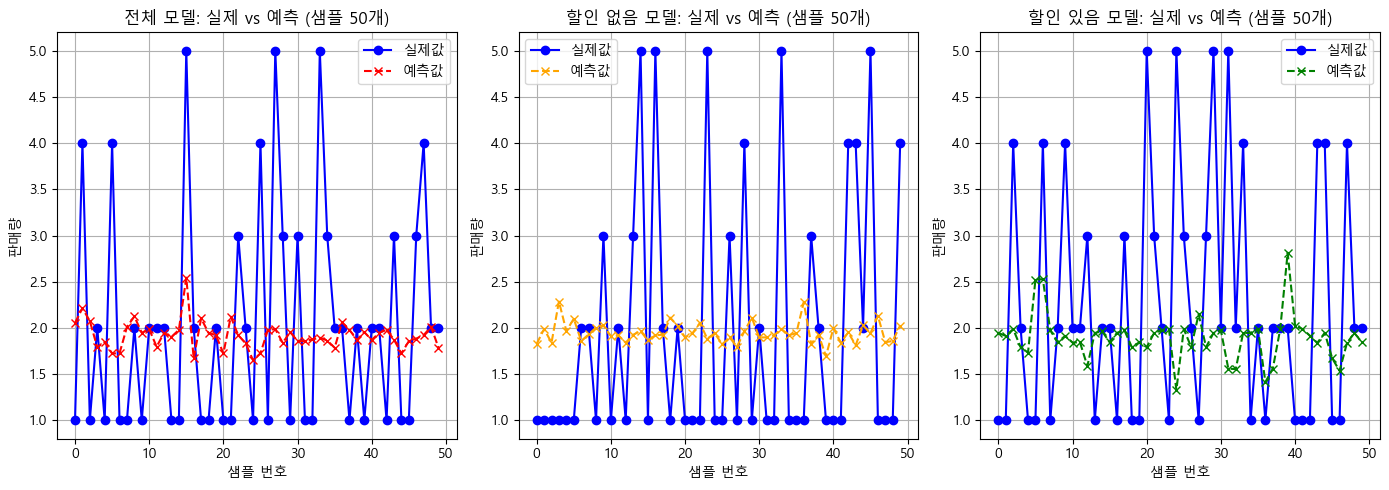

In [12]:
# 실제값/예측값 비교 그래프

plt.figure(figsize=(14, 5))

plt.subplot(1, 3, 1)
plt.plot(y_test.values[:50], label='실제값', marker='o', color='blue')
plt.plot(y_test_pred[:50], label='예측값', marker='x', color='red', linestyle='--')
plt.title("전체 모델: 실제 vs 예측 (샘플 50개)")
plt.xlabel("샘플 번호")
plt.ylabel("판매량")
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(y_test_no_dc.values[:50], label='실제값', marker='o', color='blue')
plt.plot(y_test_no_dc_pred[:50], label='예측값', marker='x', color='orange', linestyle='--')
plt.title("할인 없음 모델: 실제 vs 예측 (샘플 50개)")
plt.xlabel("샘플 번호")
plt.ylabel("판매량")
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(y_test_yes_dc.values[:50], label='실제값', marker='o', color='blue')
plt.plot(y_test_yes_dc_pred[:50], label='예측값', marker='x', color='green', linestyle='--')
plt.title("할인 있음 모델: 실제 vs 예측 (샘플 50개)")
plt.xlabel("샘플 번호")
plt.ylabel("판매량")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [13]:
# 예측결과 샘플

print("=" *50)
print("예측 결과 샘플(테스트 데이터)")
print("=" * 50)

comparison_df = pd.DataFrame({
    '실제값': y_test[:10].values,
    '예측값': y_test_pred[:10],
    '오차' : np.abs(y_test[:10].values - y_test_pred[:10])
})

comparison_df['예측값'] = comparison_df['예측값'].round(2)
comparison_df['오차'] = comparison_df['오차'].round(2)


no_dc_comparison_df = pd.DataFrame({
    '실제값': y_test_no_dc[:10].values,
    '예측값': y_test_no_dc_pred[:10],
    '오차' : np.abs(y_test_no_dc[:10].values - y_test_no_dc_pred[:10])
})

no_dc_comparison_df['예측값'] = no_dc_comparison_df['예측값'].round(2)
no_dc_comparison_df['오차'] = no_dc_comparison_df['오차'].round(2)


yes_dc_comparison_df = pd.DataFrame({
    '실제값': y_test_yes_dc[:10].values,
    '예측값': y_test_yes_dc_pred[:10],
    '오차' : np.abs(y_test_yes_dc[:10].values - y_test_yes_dc_pred[:10])
})

yes_dc_comparison_df['예측값'] = yes_dc_comparison_df['예측값'].round(2)
yes_dc_comparison_df['오차'] = yes_dc_comparison_df['오차'].round(2)

print("총 예측결과\n", comparison_df)
print("\nno_dc 예측결과\n", no_dc_comparison_df)
print("\nyes_dc 예측결과\n", yes_dc_comparison_df)

예측 결과 샘플(테스트 데이터)
총 예측결과
    실제값   예측값    오차
0    1  2.05  1.05
1    4  2.21  1.79
2    1  2.07  1.07
3    2  1.79  0.21
4    1  1.85  0.85
5    4  1.72  2.28
6    1  1.72  0.72
7    1  2.01  1.01
8    2  2.12  0.12
9    1  1.95  0.95

no_dc 예측결과
    실제값   예측값    오차
0    1  1.83  0.83
1    1  1.99  0.99
2    1  1.84  0.84
3    1  2.29  1.29
4    1  1.97  0.97
5    1  2.10  1.10
6    2  1.86  0.14
7    2  1.93  0.07
8    1  2.00  1.00
9    3  2.03  0.97

yes_dc 예측결과
    실제값   예측값    오차
0    1  1.94  0.94
1    1  1.91  0.91
2    4  1.99  2.01
3    2  1.79  0.21
4    1  1.73  0.73
5    1  2.52  1.52
6    4  2.53  1.47
7    1  1.97  0.97
8    2  1.84  0.16
9    4  1.91  2.09


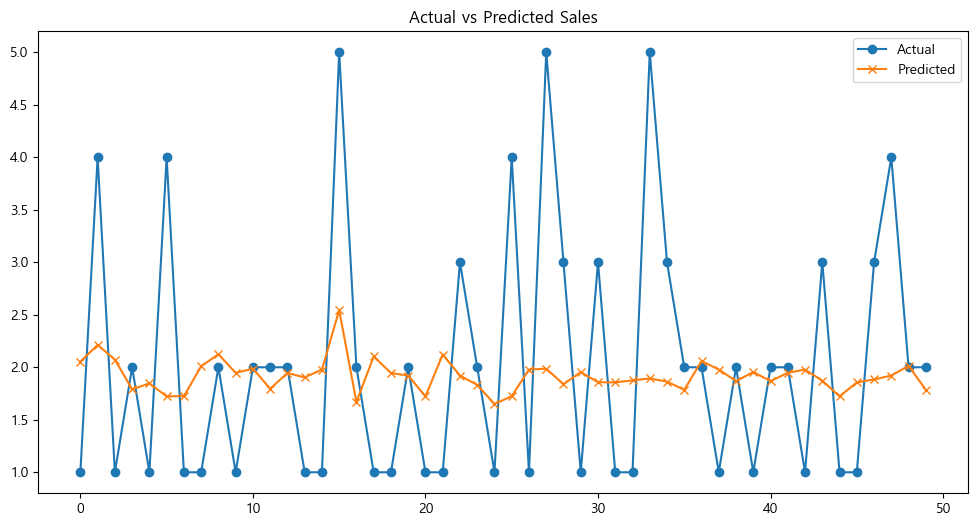

RMSE: 1.1649, MAE: 0.9250


In [14]:
# 3. 실제값 vs 예측값 시각화
plt.figure(figsize=(12, 6))
plt.plot(y_test.values[:50], label='Actual', marker='o')
plt.plot(y_test_pred[:50], label='Predicted', marker='x')
plt.legend()
plt.title("Actual vs Predicted Sales")
plt.show()

# 요약 정보 출력
print(f"RMSE: {test_rmse:.4f}, MAE: {test_mae:.4f}")

In [15]:
# 중요도 분석
print("\n" + "=" * 50)
print("특성 중요도 분석")
print("=" * 50)


feature_importance = pd.DataFrame({
    '특성': features,
    '중요도': model.feature_importances_
}).sort_values('중요도', ascending=False)


feature_importance_no = pd.DataFrame({
    '특성':features,
    '중요도': model_no_dc.feature_importances_
}).sort_values('중요도', ascending=False)


feature_importance_yes = pd.DataFrame({
    '특성':features,
    '중요도': model_yes_dc.feature_importances_
}).sort_values('중요도', ascending=False)

print(" 중요도:", feature_importance)
print("\n no dc 중요도:", feature_importance_no)
print("\n yes dc 중요도:", feature_importance_yes)


특성 중요도 분석
 중요도:             특성       중요도
1        Month  0.446995
2  day_of_week  0.387314
0        is_dc  0.165690

 no dc 중요도:             특성       중요도
1        Month  0.530494
2  day_of_week  0.469506
0        is_dc  0.000000

 yes dc 중요도:             특성       중요도
1        Month  0.558666
2  day_of_week  0.441334
0        is_dc  0.000000


In [16]:
# 2026 12월 예측 함수
def create_2026dec():
    predictions = []
    for day in range(1,32):
        date_obj = pd.to_datetime(f'2026-12-{day:02d}')
        
        predictions.append({
            'Day': date_obj.strftime('%y-%m-%d'), #날짜
            'Month':12, #12월
            'day_of_week': date_obj.dayofweek, #요일
            'is_dc':0 #할인안함이 기본값
        })
    return pd.DataFrame(predictions)

# 함수 실행 후 기초데이터 만들기
predict_df = create_2026dec()

# 모델에게 물어보기(예측)
predict_df['비할인_예측'] = model_no_dc.predict(predict_df[['is_dc', 'Month', 'day_of_week']])

predict_df['is_dc'] = 1
predict_df['할인_예측'] = model_yes_dc.predict(predict_df[['is_dc', 'Month', 'day_of_week']])

# 결과
print("2026년 12월 판매량 시뮬레이션 \n"+("="*50))
print(f"12월 총 예상 판매량 (정상가): {predict_df['비할인_예측'].sum():.1f}개")
print(f"12월 총 예상 판매량 (할인가): {predict_df['할인_예측'].sum():.1f}개")

2026년 12월 판매량 시뮬레이션 
12월 총 예상 판매량 (정상가): 57.6개
12월 총 예상 판매량 (할인가): 61.1개


c:\code\khj_1pro\.venv\lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
c:\code\khj_1pro\.venv\lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


In [17]:
# 리포트 생성
profile = ProfileReport(df, title="데이터 분석 리포트")

# 결과 보기 (주피터 노트북 내에서 출력)
profile.to_notebook_iframe()

# HTML 파일로 저장하기
profile.to_file("analysis_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 16/16 [00:00<00:00, 70.21it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [18]:
# 피클파일 만들기(모델, 스케일러 저장)

joblib.dump(model, "instax_model.pkl")
joblib.dump(scaler, "scaler.pkl")

print("모델저장완료")
print("- instax_model.pkl: 학습된 Random Forest 모델")
print("- scaler.pkl: 데이터 스케일러")

모델저장완료
- instax_model.pkl: 학습된 Random Forest 모델
- scaler.pkl: 데이터 스케일러
